## Experiment - 1: Images with Single Distinguishable Object, Visualization

1. General imports and stuff (timm provides pretrained vision transformer)
2. First we have to resize the image in a pytorch tensor (C,W,H) format. Then we have two show image functions which just let us display and image and overlays images over each other.The forward wrapper function just extracts the attention weights and saves the full atttention matrix with the CLS tokens attentions to all other tokens. The plot set function displays the six panel grid with raw imagea attentions maps and overlays.

3. The rollout function (attention_arollout_funciton) is the core algorithm which multiplies attention matrices from each layer and incorporates residual connections and then retains its probabilistic weights by normalizing.



In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision.transforms import Compose, Resize, CenterCrop, Normalize, ToTensor
from timm.models import create_model
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from tqdm.auto import tqdm
import os
import warnings
warnings.filterwarnings("ignore")
print("Libraries Imported Successfully")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")
if device == 'cuda':
    !nvidia-smi
else:
    print("CUDA device is not available.")

def to_tensor(img):
    transform_fn = Compose([Resize(249, 3),
                            CenterCrop(224),
                            ToTensor(),
                            Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    return transform_fn(img)


def show_img(img, cmap=None):
    img = np.asarray(img)
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap = cmap)
    plt.axis('off')
    plt.show()


def show_img2(img1, img2, alpha=0.8, cmap=None):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)

    plt.figure(figsize=(10, 10))
    plt.imshow(img1, cmap=cmap)
    plt.imshow(img2, alpha=alpha, cmap=cmap)
    plt.axis('off')
    plt.show()


def my_forward_wrapper(attn_obj):
    def my_forward(x):
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn
        attn_obj.cls_attn_map = attn[:, :, 0, 2:]

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
    return my_forward

def plot_set(image, attn_map, cls_weight, img_resized, cls_resized):
    # Create a figure and subplot grid
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

    # Plot the images on the subplots
    axs[0, 0].imshow(image)
    axs[0, 0].set_title('Image')

    axs[0, 1].imshow(attn_map)
    axs[0, 1].set_title('Attention Map')

    axs[0, 2].imshow(cls_weight)
    axs[0, 2].set_title('Class Weight')

    axs[1, 0].imshow(img_resized)
    axs[1, 0].set_title('Resized Image')

    # Overlay img_resized and cls_resized with alpha blending
    axs[1, 1].imshow(img_resized)
    axs[1, 1].imshow(cls_resized, alpha=0.7)
    axs[1, 1].set_title('Overlaid Images')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Display the figure
    plt.show()
def attention_rollout_function(attn_maps):
    attn_rollout = []
    I = torch.eye(attn_maps[0].shape[-1])  # Identity matrix
    prod = I
    for i, attn_map in enumerate(attn_maps):
        prod = prod @ (attn_map + I)  # Product of attention maps with identity matrix

        prod = prod / prod.sum(dim=-1, keepdim=True) # Normalize
        attn_rollout.append(prod)
      # prod = prod / prod.sum(dim=-1, keepdim=True) # Normalize
    return attn_rollout


def plot_attention_maps(attn_maps, num_cols=4, main_title = 'Attention Maps'):
    num_attn_maps = len(attn_maps)

    # Calculate the number of rows and columns for the subplots
    num_rows = (num_attn_maps + num_cols - 1) // num_cols

    # Create a figure and a grid of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows))

    # Set the main title
    fig.suptitle(main_title, fontsize=20)

    # Iterate over the attention maps and plot them in the subplots
    for i, attn_map in enumerate(attn_maps):
        row = i // num_cols
        col = i % num_cols

        if num_rows == 1:
            ax = axes[col]
        else:
            ax = axes[row, col]

        ax.imshow(attn_map, cmap='viridis')
        ax.set_title(f'Attention Map {i+1}')
        ax.axis('off')

    # Hide any unused subplots
    for j in range(num_attn_maps, num_rows * num_cols):
        row = j // num_cols
        col = j % num_cols
        if num_rows == 1:
            ax = axes[col]
        else:
            ax = axes[row, col]
        ax.axis('off')

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.3)

    # Show the figure
    plt.show()
def plot_cls_weights(cls_weights, img_resized):
    num_cls_weights = len(cls_weights)

    # Calculate the number of rows and columns for the subplots
    num_cols = 4  # Adjust as needed
    num_rows = (num_cls_weights + num_cols - 1) // num_cols

    # Create a figure and a grid of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 4 * num_rows))

    # Iterate over the cls_weights and plot them in the subplots
    for i, cls_weight in enumerate(cls_weights):
        row = i // num_cols
        col = i % num_cols

        if num_rows == 1:
            ax = axes[col]
        else:
            ax = axes[row, col]

        cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)

        ax.imshow(img_resized)
        ax.imshow(cls_resized, alpha=0.7)
        ax.set_title(f'Class Weight {i+1}')
        ax.axis('off')

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.3)

    # Show the figure
    plt.show()

def plot_heatmap(cls_weights, figsize=(12, 12)):
    # Flatten each tensor into a 1D tensor of length 196
    flattened_cls_weights = [tensor.reshape(-1) for tensor in cls_weights]

    # Create a 2D NumPy array from the flattened tensors
    data = np.array(flattened_cls_weights)

    # Create a figure with the specified size
    fig, ax = plt.subplots(figsize=figsize)

    # Create a heatmap with each row representing a tensor
    ax = sns.heatmap(data, ax=ax)

    # Set the y-axis tick labels to represent the tensor indices
    ax.set_yticks(range(len(cls_weights)))
    ax.set_yticklabels(range(len(cls_weights)))

    # Adjust the plot layout
    plt.tight_layout()

    # Show the heatmap
    plt.show()

import requests
from PIL import Image
from io import BytesIO
from torchvision.transforms import ToTensor, Resize

# Google Drive file ID from the link
file_id = '14YiaVxEJqupRIChHUwMweWmO0CWggShs'
url = f'https://drive.google.com/uc?export=download&id={file_id}'

#file_id = '1CG_ty_ZcM4doUOJRsdHR47U7FtHeVlvV'
#url = f'https://drive.google.com/uc?export=download&id={file_id}'

# Fetch the image
response = requests.get(url, stream=True)

# Check if the request was successful
if response.status_code == 200:
    # Open the image from the response content
    image = Image.open(BytesIO(response.content)).convert('RGB')  # Convert to RGB

    # Resize the image to 224x224
    resize = Resize((224, 224))
    image = resize(image)

    # Convert the image to a tensor
    to_tensor = ToTensor()
    x = to_tensor(image)
else:
    print("Failed to fetch the image. Check the link or permissions.")

Libraries Imported Successfully
Device: cuda
Sun May 11 02:39:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+--

In [ ]:
!pip install timm
import timm # Importing timm
from timm.models import create_model # Specifying create_model for import


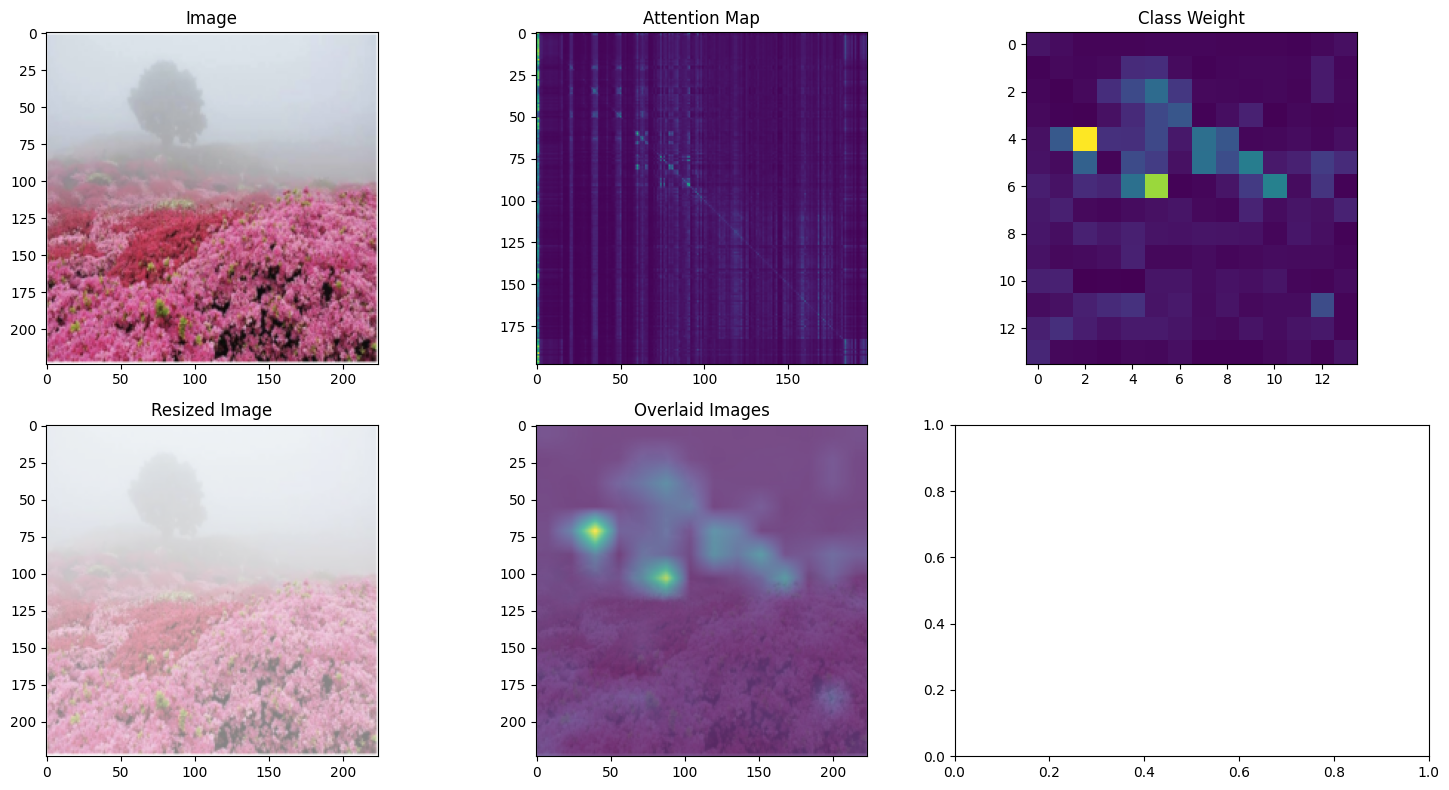

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

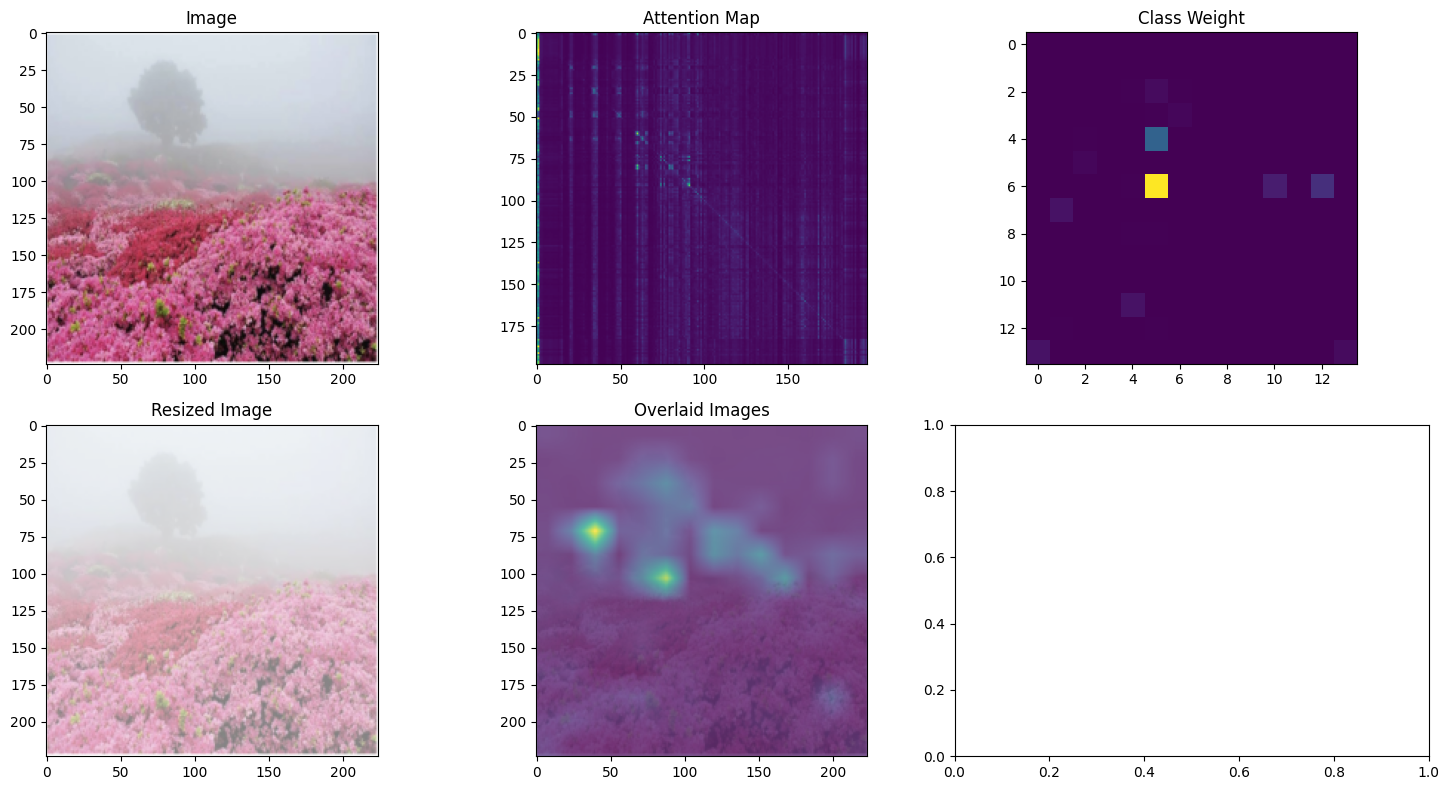

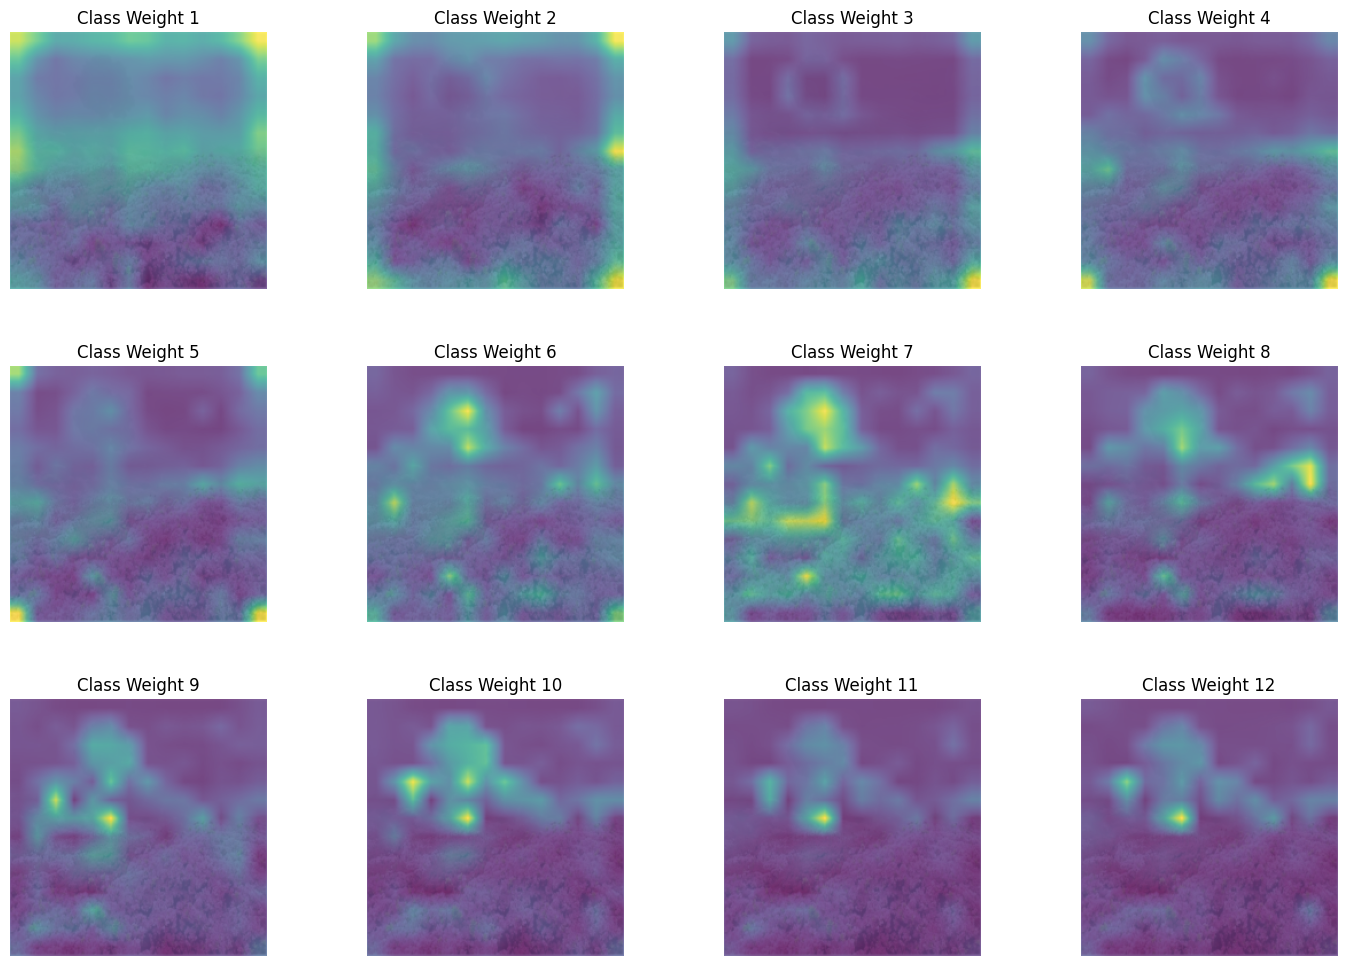

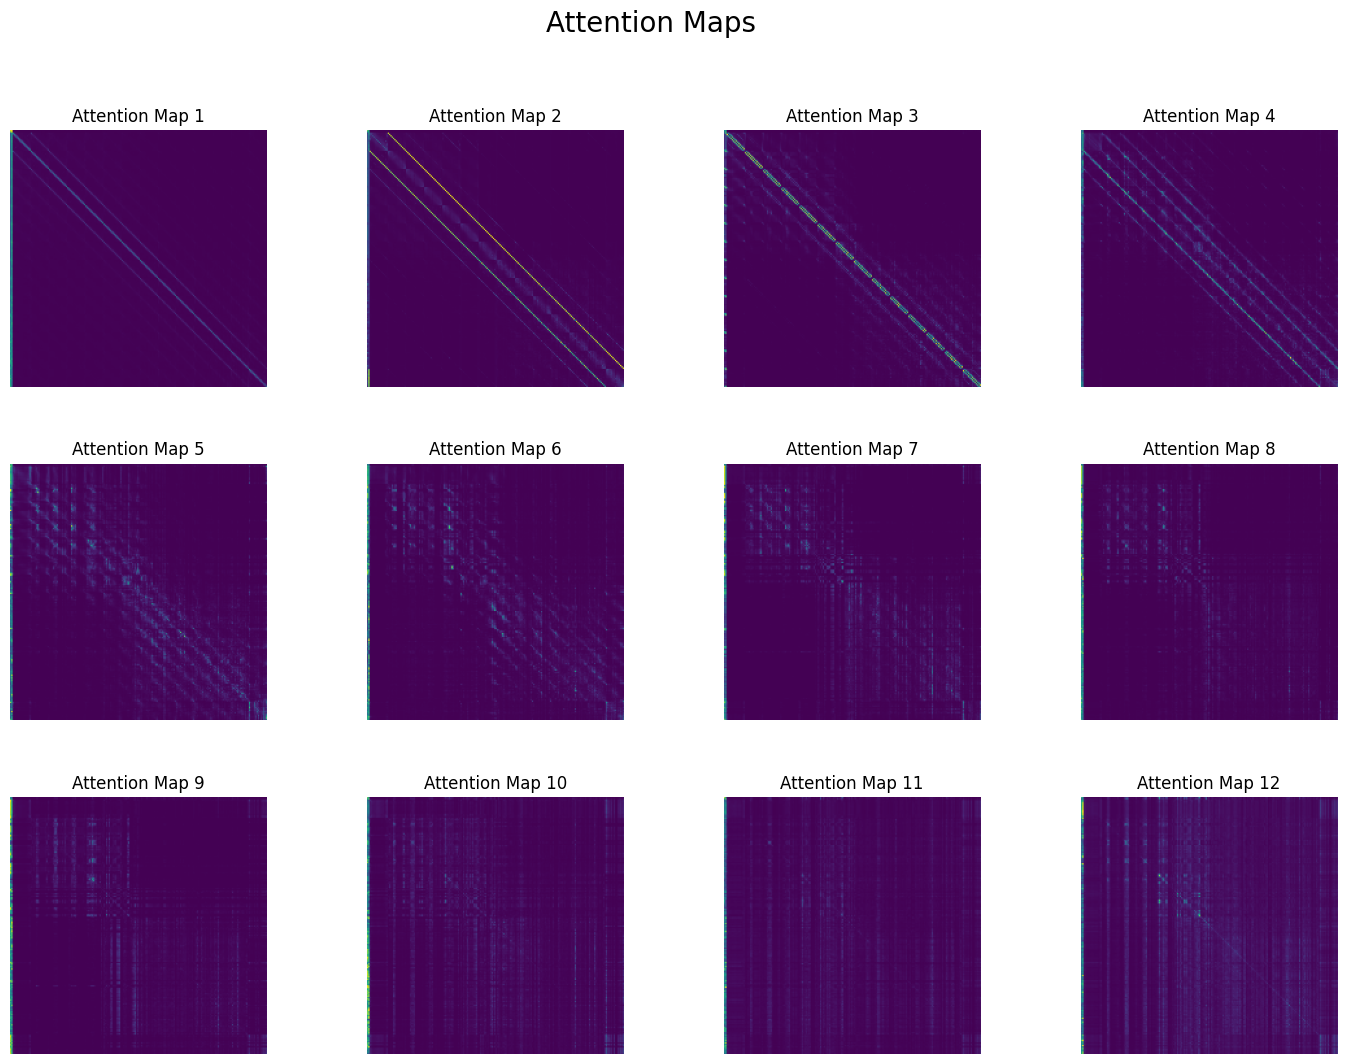

In [ ]:
model = create_model('deit_small_distilled_patch16_224', pretrained=True).to(device)
model.blocks[-1].attn.forward = my_forward_wrapper(model.blocks[-1].attn)


y = model(x.unsqueeze(0).to(device))

attn_map = model.blocks[-1].attn.attn_map.mean(dim=1).squeeze(0).detach()
cls_weight = model.blocks[-1].attn.cls_attn_map.max(dim=1).values.view(14, 14).detach()

img_resized = x.permute(1, 2, 0) * 0.5 + 0.5
cls_resized = F.interpolate(cls_weight.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)



# Ensure tensors are on the CPU
attn_map_cpu = attn_map.cpu()
cls_weight_cpu = cls_weight.cpu()
cls_resized_cpu = cls_resized.cpu()

# Call the plot_set function with CPU tensors
plot_set(image, attn_map_cpu, cls_weight_cpu, img_resized, cls_resized_cpu)

import requests
from PIL import Image
from io import BytesIO
from torchvision.transforms import ToTensor, Resize

# Google Drive file ID from the link
file_id = '14YiaVxEJqupRIChHUwMweWmO0CWggShs'
url = f'https://drive.google.com/uc?export=download&id={file_id}'
#file_id = '1CG_ty_ZcM4doUOJRsdHR47U7FtHeVlvV'
#url = f'https://drive.google.com/uc?export=download&id={file_id}'
# Fetch the image
response = requests.get(url, stream=True)

# Check if the request was successful
if response.status_code == 200:
    # Open the image from the response content
    image = Image.open(BytesIO(response.content)).convert('RGB')  # Convert to RGB

    # Resize the image to 224x224
    resize = Resize((224, 224))
    image = resize(image)

    # Convert the image to a tensor
    to_tensor = ToTensor()
    x = to_tensor(image)
else:
    print("Failed to fetch the image. Check the link or permissions.")

model = create_model('deit_small_distilled_patch16_224', pretrained=True).to(device)

# Replace forward function in all blocks
for block in tqdm(model.blocks):
    block.attn.forward = my_forward_wrapper(block.attn)


y = model(x.unsqueeze(0).to(device))

# Extract attention maps and class scores from the model's blocks
attn_maps = []
cls_weights = []
for block in tqdm(model.blocks):
    attn_maps.append(block.attn.attn_map.max(dim=1).values.squeeze(0).detach())
    cls_weights.append(block.attn.cls_attn_map.mean(dim=1).view(14, 14).detach())

# Combine class scores of all blocks
cls_weight_combined = torch.prod(torch.stack(cls_weights), dim=0)
attn_maps_prod = torch.prod(torch.stack(attn_maps), dim=0)

img_resized = x.permute(1, 2, 0) * 0.5 + 0.5
cls_resized_combined = F.interpolate(cls_weight_combined.view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1)

attn_map_last = attn_maps[11]
attn_map_last_cpu = attn_map_last.cpu()
img_resized_cpu = img_resized.cpu()
cls_weight_combined_cpu = cls_weight_combined.cpu()
cls_resized_cpu = cls_resized.cpu()

plot_set(image, attn_map_last_cpu, cls_weight_combined_cpu, img_resized_cpu, cls_resized_cpu)


attn_maps_cpu = []
for i in range(12):
    attn_map = attn_maps[i]
    attn_map_cpu = attn_map.cpu()
    attn_maps_cpu.append(attn_map_cpu)

cls_weights_cpu = []
for i in range(12):
    cls_weight = cls_weights[i]
    cls_weight_cpu = cls_weight.cpu()
    cls_weights_cpu.append(cls_weight_cpu)

plot_cls_weights(cls_weights_cpu, img_resized_cpu)

attn_maps_cpu = []
for i in range(12):
    attn_map = attn_maps[i]
    attn_map_cpu = attn_map.cpu()
    attn_maps_cpu.append(attn_map_cpu)
plot_attention_maps(attn_maps_cpu, num_cols=4)

  0%|          | 0/12 [00:00<?, ?it/s]

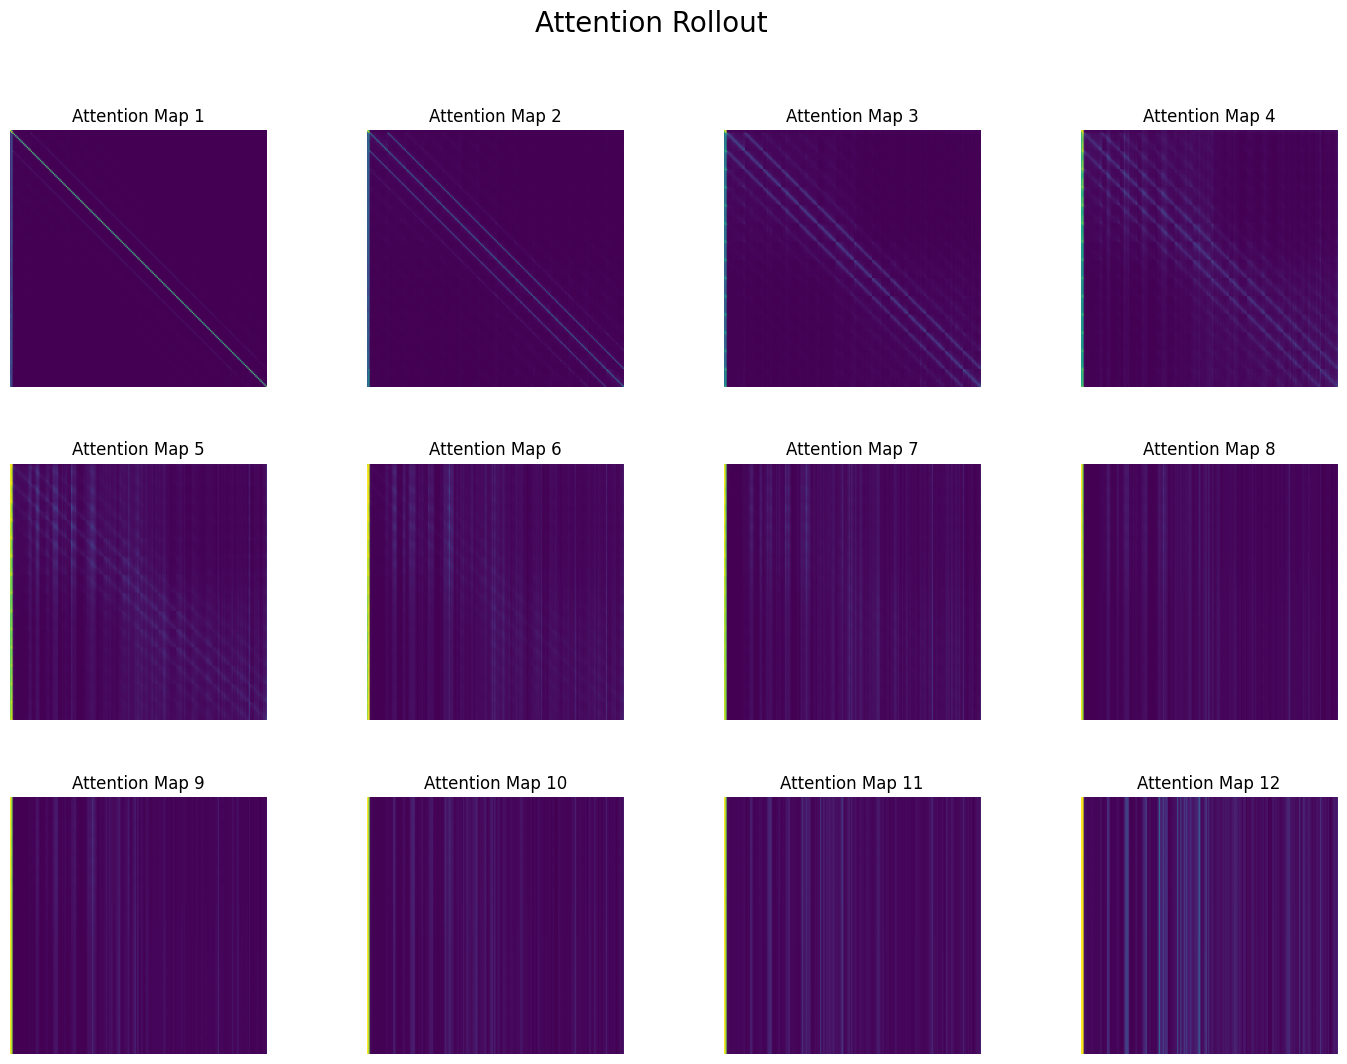

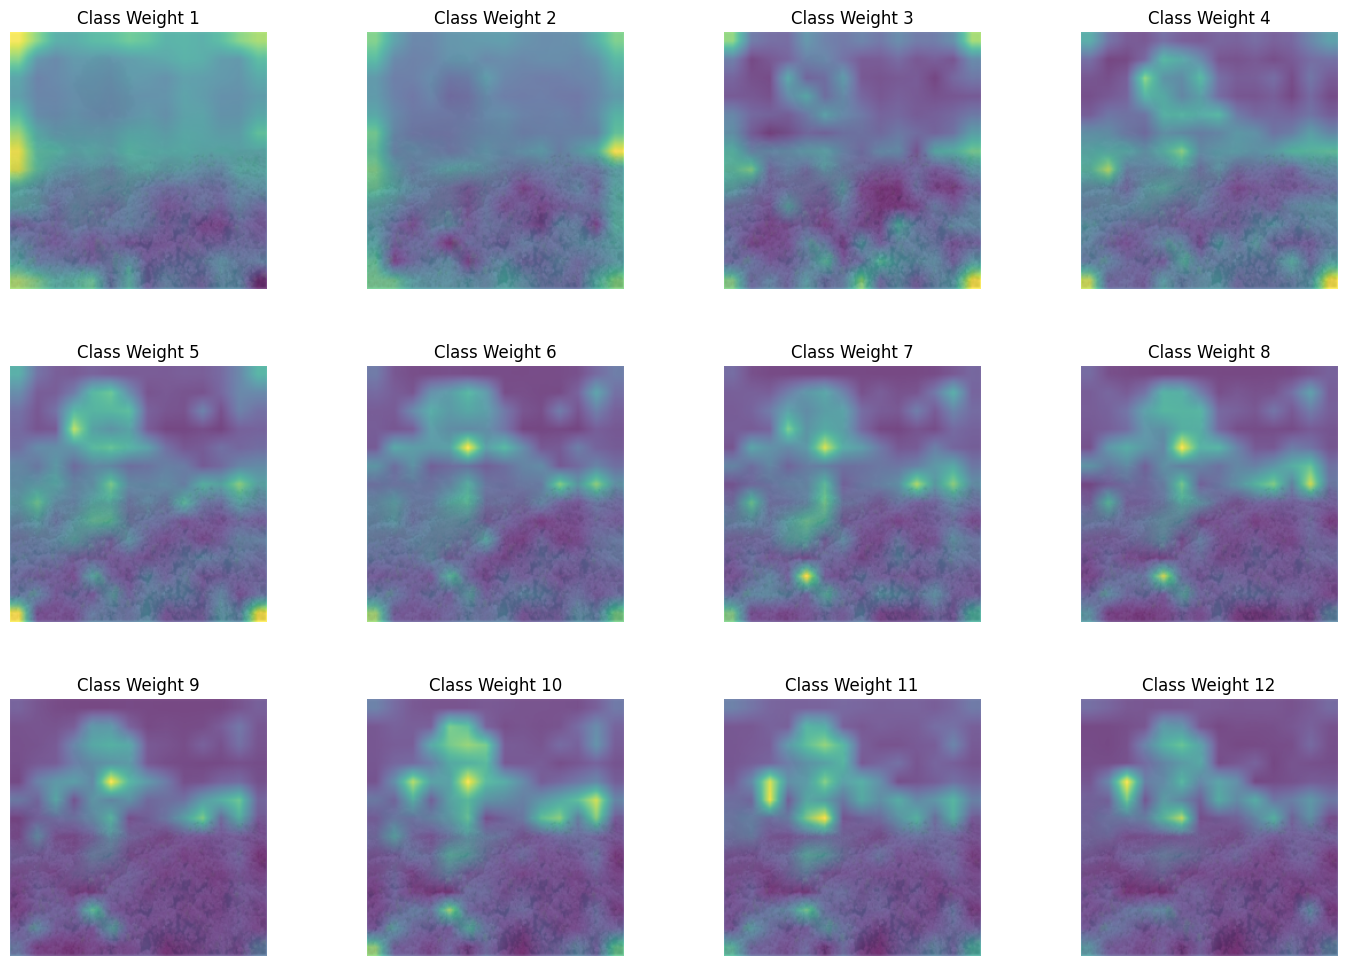

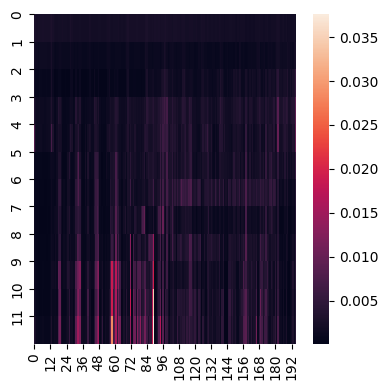

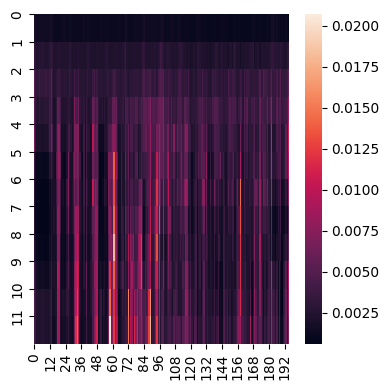

In [ ]:
attn_rollout = attention_rollout_function(attn_maps_cpu)

# For Class Weights
cls_weights_rollout = []
cls_resized_rollout = []

for i in tqdm(range(12)):
    cls_weights_rollout.append(attn_rollout[i][0, 2:])
    cls_weights_rollout[i] = cls_weights_rollout[i].view(14, 14)
    cls_resized_rollout.append(F.interpolate(cls_weights_rollout[i].view(1, 1, 14, 14), (224, 224), mode='bilinear').view(224, 224, 1))

plot_attention_maps(attn_rollout, num_cols=4, main_title="Attention Rollout")
plot_cls_weights(cls_weights_rollout, img_resized_cpu)
print("second heat attention rollout first is for raw attention")
plot_heatmap(cls_weights_cpu, figsize=(4,4))
plot_heatmap(cls_weights_rollout, figsize=(4, 4))


## Experiment - 2: Images with Multiple Distinguishable Objects, Visualization


### Step 1: Load and preprocess the example image for Vision Transformer

This cell performs the following steps:

1. **Import dependencies**  
   - `transformers.ViTForImageClassification` and `ViTImageProcessor` for loading a pretrained Vision Transformer (ViT) model and its associated image processor.  
   - `requests` for downloading files over HTTP.  
   - `PIL.Image` and `io.BytesIO` for opening and handling the image in memory.

2. **Download the image from Google Drive**  
   - Constructs a URL using the Drive file ID and fetches the raw image bytes via `requests.get`.  
   - Wraps the downloaded bytes in a `BytesIO` buffer and loads it into a PIL `Image` object.

3. **Display and save the image locally**  
   - Calls `image.show()` to open the image in a viewer for quick inspection.  
   - Saves the image to disk as `downloaded_image.png` for later reuse.

4. **Initialize the ViT model and processor**  
   - Specifies the pretrained model checkpoint (`google/vit-base-patch16-224`).  
   - Downloads and initializes both the model and its corresponding processor, which knows how to resize, crop, and normalize images for the ViT.

5. **Preprocess the downloaded image**  
   - Reopens the saved image file.  
   - Passes it through the `processor`, which converts it into a batch of PyTorch tensors shaped `(batch_size, 3, 224, 224)`.  
   - Prints out the shape of the resulting pixel tensor to confirm successful preprocessing.


In [ ]:
from transformers import ViTForImageClassification, ViTImageProcessor
import requests
from PIL import Image
from io import BytesIO

file_id = "1klB6GjDd9Rjvqq0nWb2-n5XWcGfizHcr"
url = f"https://drive.google.com/uc?export=view&id={file_id}"

response = requests.get(url)
image = Image.open(BytesIO(response.content))

# Display the image (using PIL)
image.show()

# Save the image
image.save("downloaded_image.png")
model_name = "google/vit-base-patch16-224"
model = ViTForImageClassification.from_pretrained(model_name)
processor = ViTImageProcessor.from_pretrained(model_name)

# Load the example image (dog and cat) and preprocess it
image = Image.open("downloaded_image.png")  # provided image with a dog and cat
inputs = processor(images=image, return_tensors="pt")  # resize/crop to 224x224, normalize
print("Input pixel tensor shape:", inputs["pixel_values"].shape)


Input pixel tensor shape: torch.Size([1, 3, 224, 224])


### Step 2: Define the Attention Rollout Function

> “To capture how information flows through all layers of a transformer, we add residual connections to each layer’s attention matrix, renormalize, and then multiply them cumulatively.”  
> — Abnar & Zuidema (2020)

This cell implements a function to compute the “attention rollout” across all transformer layers:

1. **Function signature and docstring**  
   - `compute_attention_rollout(attention_mats)` accepts a list of attention tensors, one per layer, each of shape `(batch_size, num_heads, N, N)`.  
   - Returns a single rollout matrix of shape `(batch_size, N, N)` that captures how input tokens attend to each other through the entire network.

2. **Initialize the rollout with the identity matrix**  
   - Extracts `batch_size` and sequence length `N` from the first attention tensor.  
   - Creates an identity matrix of shape `(N, N)`, expands it to `(batch_size, N, N)`, and uses this as the initial rollout. This accounts for residual connections.

3. **Iterate over each layer’s attention**  
   - **Head-averaging**: Converts the raw `(batch_size, heads, N, N)` tensor into a mean attention map of shape `(batch_size, N, N)`.  
   - **Add residual connection**: Adds the identity matrix back into the mean attention to preserve information flow.  
   - **Normalize**: Divides by the row-sum so that each row of the attention map sums to 1.  
   - **Propagate attention**: Multiplies the normalized attention map `A` with the current `rollout`, effectively chaining attentions layer by layer.

4. **Return the final rollout**  
   - After processing all layers, outputs the aggregated attention propagation matrix, which can be used for visualization or further analysis.


In [ ]:
import torch

def compute_attention_rollout(attention_mats):
    """
    Compute attention rollout for a list of attention matrices from each layer.
    attention_mats: list of tensors of shape (batch, heads, N, N) for each layer.
    Returns: rollout attention matrix of shape (batch, N, N).
    """
    # Start with identity matrix for each example in the batch
    batch_size = attention_mats[0].size(0)
    N = attention_mats[0].size(-1)
    # identity matrix (for residuals) expanded to batch size
    eye = torch.eye(N, device=attention_mats[0].device).expand(batch_size, N, N)
    rollout = eye  # initialize rollout as identity

    for attn in attention_mats:
        # Average over heads (assuming attn shape is batch × heads × N × N)
        attn_mean = attn.mean(dim=1)  # shape: (batch, N, N)
        # Incorporate identity (residual connection) and normalize
        A = attn_mean + torch.eye(N, device=attn.device)  # add identity
        A = A / A.sum(dim=-1, keepdim=True)               # normalize along last dim
        # Matrix multiply to propagate attention
        rollout = torch.matmul(A, rollout)


    return rollout  # shape: (batch, N, N)


> “To capture how information flows through all layers of a transformer, we add residual connections to each layer’s attention matrix, renormalize, and then multiply them cumulatively.”  
> — Abnar & Zuidema (2020)

### Step 3: Extract and reshape raw and rollout attention maps

This cell performs the following operations:

1. **Run the model to get attention weights**  
   - Calls `model(**inputs, output_attentions=True)` to obtain the output object containing attention tensors for every layer.  
   - Extracts `outputs.attentions`, a list where each element has shape `(batch_size, num_heads, num_patches+1, num_patches+1)`.

2. **Compute the raw CLS token attention map**  
   - Selects the last layer’s attention tensor (`attentions[-1]`).  
   - Averages over all heads with `mean(dim=1)` to get a `(batch_size, N, N)` map.  
   - Takes the first example in the batch and the CLS token’s attention to all patch tokens (skipping index 0 itself) via `[0, 0, 1:]`.  
   - Converts the resulting PyTorch tensor to a NumPy array for further processing.

3. **Compute the rollout-based CLS attention map**  
   - Applies the previously defined `compute_attention_rollout` on the full list of layer attentions to get a single aggregated tensor of shape `(batch_size, N, N)`.  
   - Extracts the CLS-to-patch rollout attention for the first example in the same manner and converts to NumPy.

4. **Reshape into 2D patch grids**  
   - Calculates `num_patches = sqrt(number_of_patches)` to determine the height/width of the square grid.  
   - Reshapes both `cls_attn_raw` and `cls_attn_rollout` of length `num_patches**2` into `(num_patches, num_patches)` arrays.  
   - Prints the resulting patch grid dimensions to verify the shape is correct.


In [ ]:
outputs = model(**inputs, output_attentions=True)
attentions = outputs.attentions

last_attn = attentions[-1]
last_attn_mean = last_attn.mean(dim=1)
cls_attn_raw = last_attn_mean[0, 0, 1:]
cls_attn_raw = cls_attn_raw.detach().cpu().numpy()

attn_rollout = compute_attention_rollout(list(attentions))
cls_attn_rollout = attn_rollout[0, 0, 1:].detach().cpu().numpy()

num_patches = int(cls_attn_raw.shape[0]**0.5)
attn_map_raw = cls_attn_raw.reshape(num_patches, num_patches)
attn_map_rollout = cls_attn_rollout.reshape(num_patches, num_patches)
print("Patch grid size:", attn_map_raw.shape)


Patch grid size: (14, 14)


### Step 4: Visualize Raw vs. Rollout Attention Overlays

This cell overlays the raw and rollout attention maps on the original image to compare how attention differs:

1. **Import plotting and array utilities**  
   - `matplotlib.pyplot` for creating the visualization.  
   - `numpy` for array manipulations.

2. **Resize attention maps to image resolution**  
   - Converts the normalized `(num_patches × num_patches)` attention maps into 0–255 uint8 images.  
   - Uses PIL’s `resize` with bilinear interpolation to match the original image dimensions.

3. **Create side-by-side subplots**  
   - Initializes a figure with two axes of size 10×4 inches.  

4. **Overlay attention on the original image**  
   - In each subplot, first display the original image.  
   - Then overlay the resized attention map using the “jet” colormap and an alpha blending of 0.4.  
   - Sets descriptive titles (“Raw Attention (last layer)” vs. “Attention Rollout (all layers)”) and hides axis ticks for a cleaner look.

5. **Render the visualization**  
   - Calls `plt.show()` to display the side-by-side comparison.


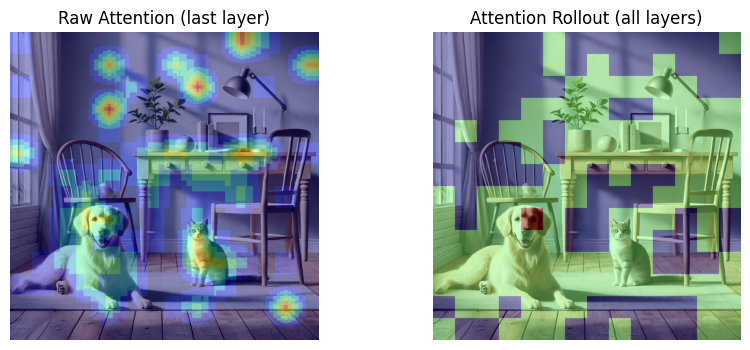

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

attn_map_raw_resized = np.array(Image.fromarray((attn_map_raw*255).astype('uint8')).resize(image.size, Image.BILINEAR))
attn_map_rollout_resized = np.array(Image.fromarray((attn_map_rollout*255).astype('uint8')).resize(image.size, Image.BILINEAR))

fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].imshow(image)
axes[0].imshow(attn_map_raw_resized, cmap='jet', alpha=0.4)
axes[0].set_title("Raw Attention (last layer)")
axes[0].axis('off')

axes[1].imshow(image)
axes[1].imshow(attn_map_rollout_resized, cmap='jet', alpha=0.4)
axes[1].set_title("Attention Rollout (all layers)")
axes[1].axis('off')
plt.show()


In [ ]:
import math

def entropy(prob_dist):
    return -sum(p*math.log(p+1e-9) for p in prob_dist)

raw_entropy = entropy((cls_attn_raw / cls_attn_raw.sum()))
rollout_entropy = entropy((cls_attn_rollout / cls_attn_rollout.sum()))
print(f"Entropy of raw attention distribution: {raw_entropy:.3f}")
print(f"Entropy of rollout attention distribution: {rollout_entropy:.3f}")


Entropy of raw attention distribution: 4.689
Entropy of rollout attention distribution: 5.253


# Experiment - 3: Images with Multiple Distinguishable Objects, Checking Cosine Similarity



### Step 1: Download and Prepare the Image

1. **Import the required libraries**  
   - `requests` to perform HTTP GET requests  
   - `BytesIO` to wrap raw bytes as a file-like object  
   - `PIL.Image` from the Pillow library to handle image operations  

2. **Construct the download URL**  
   - Use the Google Drive `file_id` to build a direct-download link.  

3. **Fetch and open the image**  
   - Call `requests.get(url)` to retrieve the image bytes.  
   - Wrap the response content in `BytesIO` and pass to `Image.open()`.

4. **Display and save the image locally**  
   - `image.show()` pops up the image in your environment.  
   - `image.save("downloaded_image.jpg")` writes it to disk for reuse.

5. **Reload and inspect dimensions**  
   - Re-open the saved file in RGB mode to ensure consistent channel ordering.  
   - Print `image.size` to check the width and height (e.g., `(768, 768)`).  

This sets up a local copy of your image and confirms its dimensions before any further processing.


In [ ]:
import requests
from io import BytesIO
from PIL import Image

file_id = "1-i0Solb447uVIENbDWjChJ3vQ9fox3MB"
url = f"https://drive.google.com/uc?export=view&id={file_id}"

response = requests.get(url)
image = Image.open(BytesIO(response.content))

# Display the image (using PIL)
image.show()

# Save the image
image.save("downloaded_image.png")

image_path = "downloaded_image.png"  # provided image file
image = Image.open(image_path).convert("RGB")
print(f"Original image size: {image.size}")  # e.g., (768, 768)



Original image size: (1024, 1024)


### Step 2: Run Object Detection with a Pre-trained DETR Model

1. **Import the Hugging Face pipeline**  
   - `pipeline` provides a high-level API to load models for common tasks.

2. **Initialize the object-detection pipeline**  
   - Specify task as `"object-detection"`.  
   - Use the `"facebook/detr-resnet-50"` model, which is DETR (DEtection TRansformer) built on a ResNet-50 backbone for end-to-end object detection.

   ```python
   detector = pipeline("object-detection", model="facebook/detr-resnet-50")


In [ ]:
from transformers import pipeline

# Initialize an object detection pipeline with a pre-trained DETR model
detector = pipeline("object-detection", model="facebook/detr-resnet-50")

# Perform object detection on the image
detections = detector(image)

# Print detected objects and their bounding boxes
for det in detections:
    label = det['label']
    score = det['score']
    box = det['box']
    print(f"Detected {label} (confidence {score:.2f}) at {box}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

Detected chair (confidence 1.00) at {'xmin': 605, 'ymin': 526, 'xmax': 932, 'ymax': 1012}
Detected dining table (confidence 0.99) at {'xmin': 28, 'ymin': 594, 'xmax': 481, 'ymax': 996}
Detected dog (confidence 1.00) at {'xmin': 0, 'ymin': 41, 'xmax': 442, 'ymax': 513}
Detected cat (confidence 0.97) at {'xmin': 630, 'ymin': 50, 'xmax': 943, 'ymax': 497}


### Step 3: Crop and Save Each Detected Object

1. **Initialize storage**  
   - Create an empty dictionary `object_images` to hold each cropped object.

2. **Iterate over detections**  
   - For each detection dict in `detections`:  
     - Extract the `label` (object class)  
     - Extract the bounding `box` coordinates

3. **Compute integer crop coordinates**  
   - Round the floating-point box values to integers:  
     ```python
     left, top = int(box['xmin']), int(box['ymin'])
     right, bottom = int(box['xmax']), int(box['ymax'])
     ```
   - These define the crop rectangle `(left, top, right, bottom)`.

4. **Crop the image**  
   - Use `image.crop((left, top, right, bottom))` to extract the region containing the object.

5. **Store and save**  
   - Save the cropped `PIL.Image` in `object_images[label]` for later use.  
   - Write each crop out to disk as `"label.jpg"`, e.g. `"dog.jpg"`, `"chair.jpg"`.


In [ ]:
# Crop each detected object from the image
object_images = {}
for det in detections:
    label = det['label']
    box = det['box']
    # Round box coordinates and crop (left, top, right, bottom)
    left, top = int(box['xmin']), int(box['ymin'])
    right, bottom = int(box['xmax']), int(box['ymax'])
    crop_img = image.crop((left, top, right, bottom))
    object_images[label] = crop_img
    crop_img.save(f"{label}.jpg")  # save or hold in dict for later use


### Step 4: Load the Pre-trained ViT Model and Enable Attention Outputs

1. **Import required modules**  
   - `torch` for tensor operations (not directly used here but often needed downstream)  
   - `ViTModel` for the Vision Transformer backbone  
   - `ViTImageProcessor` to handle image preprocessing (resize, normalization)

2. **Specify the model checkpoint**  
   - `model_name = "google/vit-base-patch16-224-in21k"`  
   - This ViT variant is pre-trained on the larger ImageNet-21k dataset for stronger feature representations.

3. **Initialize the processor and model**  
   - `processor = ViTImageProcessor.from_pretrained(model_name)`  
   - `vit_model = ViTModel.from_pretrained(model_name)`  
   - The processor will later convert PIL images into the tensor format required by ViT.

4. **Configure the model to output attention maps**  
   - `vit_model.config.output_attentions = True`  
   - This ensures that on forward passes, the model returns the attention weights from each layer, which are essential for computing attention rollout.


In [ ]:
import torch
from transformers import ViTModel, ViTImageProcessor

# Load a pre-trained ViT model and its image processor
model_name = "google/vit-base-patch16-224-in21k"  # pre-trained on ImageNet-21k
processor = ViTImageProcessor.from_pretrained(model_name)
vit_model = ViTModel.from_pretrained(model_name)

# Ensure the model returns attention weights
vit_model.config.output_attentions = True


### Step 5: Compute Standard [CLS] Embeddings for Each Object

1. **Initialize storage**  
   - Create an empty dictionary `embeddings_std` to hold each object’s embedding.

2. **Preprocess each cropped image**  
   - For every `(label, obj_img)` pair in `object_images`:  
     - Use `processor(images=obj_img, return_tensors="pt")` to convert the PIL image into the tensor inputs required by the ViT model.

3. **Forward pass through ViT**  
   - Call `vit_model(**inputs)` to obtain model outputs, including the last hidden states.

4. **Extract the [CLS] token embedding**  
   - In Vision Transformers, the first token (`index 0`) of the sequence is the global “classification” token.  
   - Retrieve it via `outputs.last_hidden_state[0, 0, :]`, yielding a tensor of shape `[768]`.

5. **Store and report**  
   - Detach the embedding from the computation graph with `.detach()` and save it in `embeddings_std[label]`.  
   - Print the label and the embedding shape to confirm successful extraction.

This step gives you a baseline embedding for each detected object without applying attention rollout.


In [ ]:
embeddings_std = {}
for label, obj_img in object_images.items():
    inputs = processor(images=obj_img, return_tensors="pt")
    outputs = vit_model(**inputs)
    # pick out the [CLS] embedding and remove the batch dim
    cls_embedding = outputs.last_hidden_state[0, 0, :]      # shape: [768]
    embeddings_std[label] = cls_embedding.detach()
    print(f"{label} embedding (no rollout): shape {cls_embedding.shape}")


chair embedding (no rollout): shape torch.Size([768])
dining table embedding (no rollout): shape torch.Size([768])
dog embedding (no rollout): shape torch.Size([768])
cat embedding (no rollout): shape torch.Size([768])


### Step 6: Compute Attention Rollout and Derive Rollout-Based Embeddings

1. **Implement attention rollout**  
   - The `compute_attention_rollout(attention_matrices)` function integrates attention scores across all Transformer layers, following the method of Abnar & Zuidema (2020)[^1].  
     - Starts from an identity matrix to represent initial self-attention.  
     - For each layer’s average-attention matrix:  
       - Adds identity (to capture residual connections)  
       - Normalizes each row so weights sum to 1  
       - Multiplies cumulatively to produce a joint attention matrix  

2. **Generate embeddings with rollout**  
   - For each detected object image (`obj_img`):  
     1. Preprocess via the `processor` and run the ViT model with `output_attentions=True`  
     2. Extract per-layer attention tuples (`outputs.attentions`), each of shape `(1, heads, tokens, tokens)`  
     3. Collapse heads by averaging to get a list of `(tokens, tokens)` matrices  
     4. Apply `compute_attention_rollout(...)` to obtain the full-layer rollout matrix  
     5. Isolate the `[CLS] → patch` attention row (index 0 to patches 1…N) to get `patch_importance`  
     6. Normalize these importance scores to sum to 1 (`patch_weights`)  
     7. Weight the patch embeddings (`outputs.last_hidden_state[:,1:,:]`) by `patch_weights` and sum to form the final embedding  

3. **Store and confirm**  
   - Save each computed rollout-based embedding into `embeddings_rollout[label]`  
   - Print out the shape (e.g., `[768]`) to verify successful computation  

[^1]: Abnar, S. and Zuidema, W. (2020). *Quantifying Attention Flow in Transformers*. Proceedings of EMNLP.


In [ ]:
def compute_attention_rollout(attention_matrices):
    """
    Compute attention rollout for a list of attention matrices (one per Transformer layer).
    Each attention matrix should be of shape (tokens, tokens) after averaging heads.
    Returns a rollout matrix of shape (tokens, tokens) indicating integrated attention.
    """
    num_tokens = attention_matrices[0].shape[0]
    # Start with identity (each token fully attends to itself initially)
    joint_attn = torch.eye(num_tokens)
    for attn in attention_matrices:
        # Add identity to attention and normalize (to account for residual connection)
        attn_aug = attn + torch.eye(num_tokens)
        attn_norm = attn_aug / attn_aug.sum(dim=-1, keepdim=True)
        # Multiply into joint attention (cumulative product of matrices)
        joint_attn = attn_norm @ joint_attn
    return joint_attn

embeddings_rollout = {}  # store rollout-based embeddings
for label, obj_img in object_images.items():
    inputs = processor(images=obj_img, return_tensors="pt")
    outputs = vit_model(**inputs, output_attentions=True)
    attentions = outputs.attentions  # tuple of (layers,) each of shape (1, heads, tokens, tokens)
    # 1. Compute average attention per layer (collapse heads)
    attn_mats = [attn[0].mean(dim=0) for attn in attentions]  # list of (tokens, tokens) for each layer
    # 2. Compute attention rollout across layers
    rollout_matrix = compute_attention_rollout(attn_mats)
    # 3. Derive the class token's view of patch importance:
    num_tokens = rollout_matrix.size(0)
    # Index 0 is [CLS], indices 1...N are patch tokens
    patch_importance = rollout_matrix[0, 1:]  # influence of each patch on the [CLS] token
    # Normalize the patch importance scores to sum to 1
    patch_weights = patch_importance / patch_importance.sum()
    # 4. Compute weighted sum of patch embeddings using these weights
    patch_embeddings = outputs.last_hidden_state[:, 1:, :].squeeze(0)  # shape (num_patches, hidden_size)
    weighted_patch_embed = (patch_weights.unsqueeze(-1) * patch_embeddings).sum(dim=0)
    embeddings_rollout[label] = weighted_patch_embed.detach()
    print(f"{label} embedding (with rollout): shape {weighted_patch_embed.shape}")


chair embedding (with rollout): shape torch.Size([768])
dining table embedding (with rollout): shape torch.Size([768])
dog embedding (with rollout): shape torch.Size([768])
cat embedding (with rollout): shape torch.Size([768])


### Step 7: Compare Embedding Similarities Between Objects

1. **Gather object labels**  
   - Extract the list of detected object names from `embeddings_std.keys()`.

2. **Define a cosine similarity helper**  
   - `cosine_sim(vec1, vec2)` wraps `torch.nn.functional.cosine_similarity` and returns a scalar, making it easy to compare two 1-D vectors.

3. **Loop over unique object pairs**  
   - Use two nested loops, skipping pairs where `j ≤ i` to avoid duplicate and self-comparisons.
   - For each pair `(label_i, label_j)`, compute:  
     - `sim_std`: similarity between the standard [CLS] embeddings  
     - `sim_roll`: similarity between the attention-rollout-based embeddings

4. **Store results in dictionaries**  
   - `sim_matrix_std[(label_i, label_j)] = sim_std`  
   - `sim_matrix_rollout[(label_i, label_j)] = sim_roll`

5. **Print the comparison**  
   - Output a formatted line for each pair

This step quantifies how object relationships differ when using plain [CLS] embeddings versus attention-rollout-weighted embeddings.  


In [ ]:
import torch.nn.functional as F

labels = list(embeddings_std.keys())  # e.g., ['dog','cat','chair','dining table']
# Helper to compute cosine similarity
def cosine_sim(vec1, vec2):
    return F.cosine_similarity(vec1.unsqueeze(0), vec2.unsqueeze(0)).item()

# Compute and display cosine similarities
sim_matrix_std = {}
sim_matrix_rollout = {}
for i, label_i in enumerate(labels):
    for j, label_j in enumerate(labels):
        if j <= i:  # avoid duplicate/calculating self-similarity
            continue
        sim_std = cosine_sim(embeddings_std[label_i], embeddings_std[label_j])
        sim_roll = cosine_sim(embeddings_rollout[label_i], embeddings_rollout[label_j])
        sim_matrix_std[(label_i, label_j)] = sim_std
        sim_matrix_rollout[(label_i, label_j)] = sim_roll
        print(f"{label_i} vs {label_j}: standard sim = {sim_std:.3f}, rollout sim = {sim_roll:.3f}")


chair vs dining table: standard sim = 0.444, rollout sim = 0.427
chair vs dog: standard sim = 0.084, rollout sim = 0.039
chair vs cat: standard sim = 0.089, rollout sim = 0.075
dining table vs dog: standard sim = 0.072, rollout sim = 0.041
dining table vs cat: standard sim = 0.070, rollout sim = 0.088
dog vs cat: standard sim = 0.541, rollout sim = 0.326
